running for TSS spin with nprocs= 4


100%|███████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2647.08it/s]


CPU times: user 483 ms, sys: 171 ms, total: 654 ms
Wall time: 1h 9min 15s


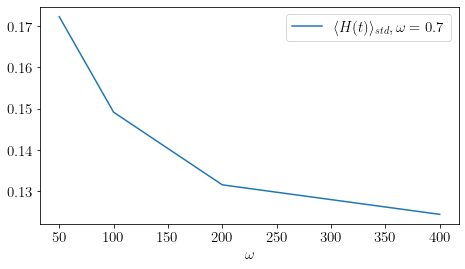

In [57]:
%%time
import h5py
from qutip import mesolve, basis, jmat, Options, expect, Qobj
from multiprocessing import Pool
from tqdm import tqdm
from scipy.special import jn_zeros
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,
    "font.family": "sans-serif","font.size": 15,"font.sans-serif": ["Computer Modern"]})

def drive(t, args):
    w = args['omega']
    h = args['h']
    h0 = args['h0']
    return h * np.sin(w*t) + h0

def get_hamiltonians(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/(N-1)                                     
    H0 = kn * sz **2 
    H1 = 2 * sx
    return H0,H1

def sys_evolve(w,N,opts):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    T = 2 * np.pi/w
    h = jn_zeros(0,5)[1]* w / 4.0
    params = {'h0':np.pi/32, 'h':h,'omega':w, 'N':N} 
    H0, H1 = get_hamiltonians(N)
    H = [H0,[H1,drive]]
    en, sts = sx.eigenstates() 
    rho0 = sts[0]
    times = np.linspace(0,200*T, 1000)
    hbar = []
    out = mesolve(H, rho0, times, [], [], args = params, options=opts)
    psi_ts = out.states
    
    for i,t in enumerate(times):
        Ht = H0 + H1 * drive(t, params)
        hbar.append(expect(Qobj(Ht),psi_ts[i]))
    hbar = (np.array(hbar)/N).reshape(len(times),1)
    return hbar.real, (times/(2*np.pi/w)).reshape(len(times),1)

if __name__ == '__main__':
    Ns = [50,100,200,400]
    nprocs = len(Ns)
    w = 0.7

    p = Pool(processes = nprocs)
    print("running for TSS spin with nprocs=",nprocs)
    opts = Options(nsteps=1e5, num_cpus=nprocs, openmp_threads=1, atol=1e-12, rtol=1e-14)
    data = np.array(p.starmap(sys_evolve,tqdm([(w,N, opts) for N in Ns])))
    
    hbaravg, hbarvar, hbarstd, hbars=[],[],[], []
    for i, N in enumerate(Ns):
        hbar = data[i][0][:,0]
        times = data[i][1][:,0]

        hbars.append(hbar)
        hbaravg.append(np.average(hbar))
        hbarstd.append(np.std(hbar))
        #hbarvar.append(statistics.variance(hbar, statistics.mean(hbar)))

    plt.plot(Ns,hbarstd,  label=fr'$\langle H(t)\rangle_{{std}}, \omega={w}$')
    plt.xlabel(r'$\omega$')
    plt.legend()

    fname = 'hbar_stdN50100200400_w' + str(w) + '.hdf5'
    with h5py.File(fname,'w') as hf:
        hbar_dset = hf.create_dataset('hbars', np.shape(np.array(hbars)), data = np.array(hbars))
        times_dset = hf.create_dataset('times', np.shape(np.array(times)), data = np.array(times))
        Nn = hf.create_dataset('Ns', np.shape(np.array(Ns)), data = np.array(Ns))
        hf.attrs['w'] = w

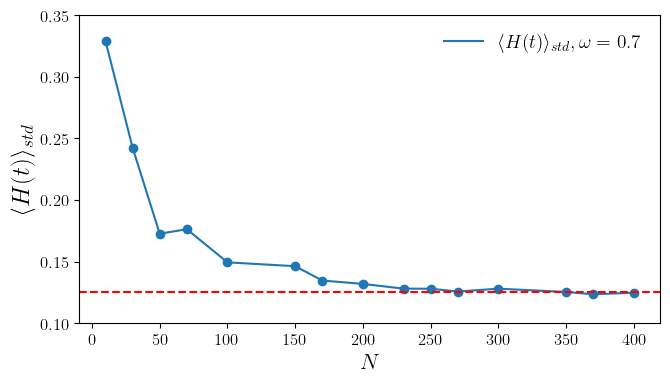

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,
    "font.family": "sans-serif","font.size": 12,"font.sans-serif": ["Computer Modern"]})

filename = 'hbar_stdN50100200400fake_w0.7.hdf5'

with h5py.File(filename, "r") as f:
    hbars = f['hbars'][()]
    times = f['times'][()]
    Ns = f['Ns'][()]
    w = f.attrs['w']
    
hbaravg, hbarstd =[], []
for i,N in enumerate(Ns):
    hbar = hbars[i]
    #hbaravg.append(np.average(hbar))
    hbarstd.append(np.std(hbar))

#plt.plot(Ns,hbaravg, label=fr'$\langle H(t)\rangle_{{avg}} , \omega={w}$')
plt.plot(Ns,hbarstd, label=fr'$\langle H(t)\rangle_{{std}}, \omega={w}$')
plt.scatter(Ns,hbarstd)

plt.xlabel(r'$N$',fontsize=16)
plt.ylabel(r"$\langle H(t)\rangle_{{std}}$",fontsize=18)

plt.axhline(y=0.125, linestyle = '--', color='red')
plt.ylim(.1, .35)
plt.legend(frameon=False, fontsize=14)
figname = 'hbar_avg_std_w' + str(w) +'.jpg'
#plt.savefig(figname, dpi= 500)
plt.show()